Syed Hammad Ali (sa04324), Muhammad Umer Anwar (ma05200)

## Q1

(a) Object detection is a computer vision approach that enables the identification and localization of items inside an image or video. With this type of identification and localization, object detection can be used to precisely name and count things in a scene, as well as determine and track their specific locations. Object detection is the process of identifying instances of semantic items of a particular class inside digital photos and videos. Face detection and pedestrian detection are well-researched object detection fields.

(b) Object detection models receive an image as input and output the images with bounding boxes and labels on detected objects.


(c) In image recognition, the AI model assigns a single high-level label to an image or video. In object detection, the AI model locates and identifies each and every noteworthy object in the image or video. 


(d) One-Stage Object Detection Models refer to a class of object detection models which are one-stage, i.e. models which skip the region proposal stage of two-stage models and run detection directly over a dense sampling of locations. These types of models usually have faster inference (possibly at the cost of performance).


(e) One-Stage Object Detection Models include generation of region proposals, e.g. by selective search as in R-CNN and Fast R-CNN, or by a Region Proposal Network (RPN) as in Faster R-CNN as well as Object classification for each region proposal. Additionally, other things can be done such as bounding-box regression for refining the region proposals, binary-mask prediction etc.




## Q2

In [6]:
# !git clone https://github.com/1297rohit/RCNN.git

In [7]:
# !unzip -qq RCNN/Images.zip -d ./
# !unzip -qq RCNN/Airplane_Annotations.zip -d ./

In [22]:
!pip install opencv-contrib-python
!pip install pandas
!pip install matplotlib
!pip install sklearn

     |████████████████████████████████| 30.6 MB 316 kB/s eta 0:00:01
     |████████████████████████████████| 306 kB 140 kB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=53bef6d25992b8f8d79ba73a199d1b8ec14d69382c0e497ecc7ea49bcc9f5d0d
  Stored in directory: /home/mh05205/.cache/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


In [13]:
import os,cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

2022-05-15 15:38:47.211358: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [14]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [15]:
def get_iou(bb1, bb2):

    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    assert iou >= 0.0
    assert iou <= 1.0
    
    return iou

In [16]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-05-15 15:38:48.797059: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-15 15:38:48.797730: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-15 15:38:48.824444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 15:38:48.824920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-05-15 15:38:48.825007: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-15 15:38:48.855486: I tensorflow/stream_executor/platform/default/dso_load

In [17]:
# %%script echo skipping
train_images=[]
train_labels=[]

annot = "./Airplanes_Annotations"
path = "./Images"

for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            # print(e,filename)
            image = cv2.imread(os.path.join(path, filename))
            df = pd.read_csv(os.path.join(annot, i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        # print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside


In [18]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [19]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

2022-05-15 15:42:38.698908: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-15 15:42:38.717601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 15:42:38.719204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-05-15 15:42:38.760699: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

In [20]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(inputs = vggmodel.inputs, outputs = predictions)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

lenc = MyLabelBinarizer()

Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [24]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1,
             save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000,
                                 validation_data= testdata, validation_steps=2,
                                 callbacks=[checkpoint,early])

/home/mh05205/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-05-15 15:44:51.687817: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-15 15:44:51.688645: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Epoch 1/1000


2022-05-15 15:44:52.135470: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-15 15:44:52.443960: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-05-15 15:44:53.843294: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2022-05-15 15:44:54.148791: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-15 15:44:54.148899: W tensorflow/str

 2/10 [=====>........................] - ETA: 0s - loss: 3.1322 - accuracy: 0.3828  

2022-05-15 15:45:38.745937: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'



10/10 [==============================] - 50s 364ms/step - loss: 2.6867 - accuracy: 0.5989 - val_loss: 0.3838 - val_accuracy: 0.8750

Epoch 00001: val_loss improved from inf to 0.38381, saving model to ieeercnn_vgg16_1.h5
Epoch 2/1000
10/10 [==============================] - 3s 280ms/step - loss: 0.3973 - accuracy: 0.8495 - val_loss: 0.3315 - val_accuracy: 0.8906

Epoch 00002: val_loss improved from 0.38381 to 0.33148, saving model to ieeercnn_vgg16_1.h5
Epoch 3/1000
10/10 [==============================] - 3s 307ms/step - loss: 0.5558 - accuracy: 0.8209 - val_loss: 0.2577 - val_accuracy: 0.8750

Epoch 00003: val_loss improved from 0.33148 to 0.25769, saving model to ieeercnn_vgg16_1.h5
Epoch 4/1000
10/10 [==============================] - 3s 282ms/step - loss: 0.2691 - accuracy: 0.8868 - val_loss: 0.3105 - val_accuracy: 0.8750

Epoch 00004: val_loss did not improve from 0.25769
Epoch 5/1000
10/10 [==============================] - 3s 279ms/step - loss: 0.2340 - accuracy: 0.9235 - val_l

2022-05-15 16:02:19.530168: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-15 16:02:19.878963: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-15 16:02:20.257735: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_75' is not defined for option 'gpu-name'

2022-05-15 16:02:20.600007: W tensorflow/stream_executor/gpu/

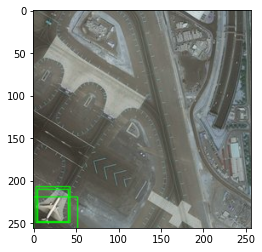

In [27]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.70:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)
        break